In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load data
df = pd.read_csv('../data/processed_data.csv', parse_dates=['date'], index_col='date')

# Handle missing values
df.dropna(inplace=True)

# Normalize data (key for distance-based models)
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['Appliances', 'T_out', 'lights', 'RH_1']]),
                         columns=['Appliances', 'T_out', 'lights', 'RH_1'],
                         index=df.index)

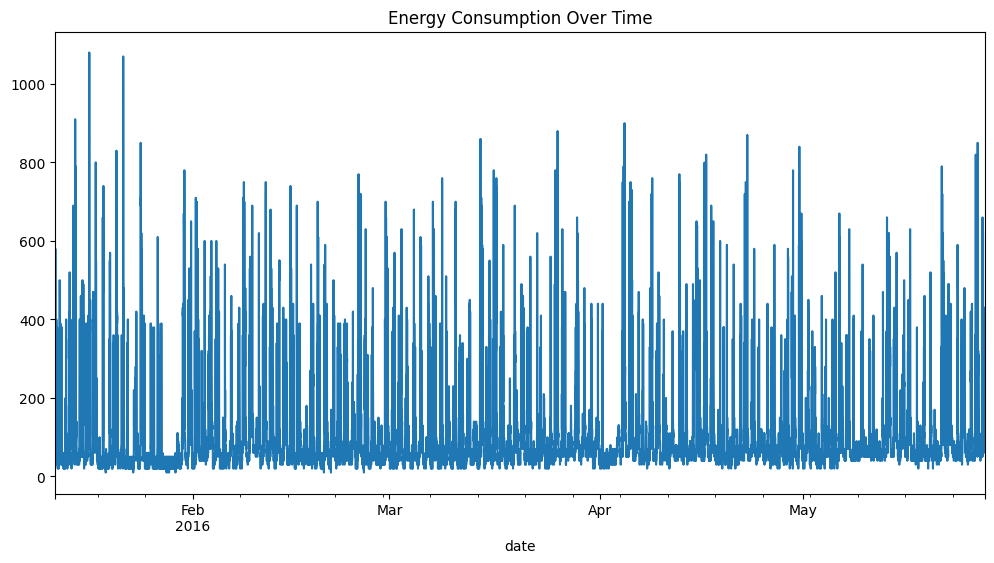

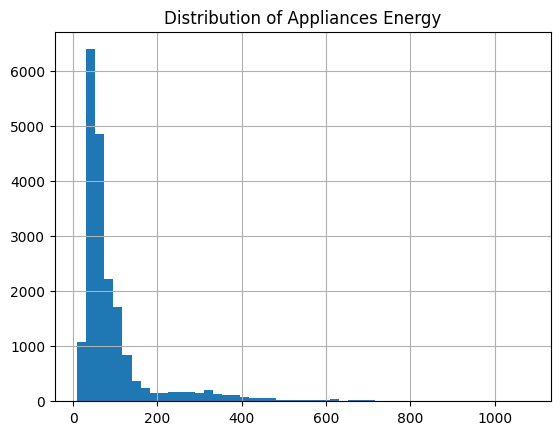

In [8]:
import matplotlib.pyplot as plt

# Plot energy consumption
df['Appliances'].plot(figsize=(12, 6), title='Energy Consumption Over Time')
plt.show()

# Check distribution
df['Appliances'].hist(bins=50)
plt.title('Distribution of Appliances Energy')
plt.show()

In [2]:
print(f"Dataset loaded with {len(df)} data points")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Dataset loaded with 19735 data points
Date range: 2016-01-11 17:00:00 to 2016-05-27 18:00:00


In [5]:
# Calculate Z-score for Appliances column
mean_appliances = df['Appliances'].mean()
std_appliances = df['Appliances'].std()

# Calculate Z-score for each data point
df['z_score'] = (df['Appliances'] - mean_appliances) / std_appliances

# Define threshold for anomaly detection
z_threshold = 3.0

# Identify anomalies (absolute Z-score > threshold)
df['is_anomaly_zscore'] = np.abs(df['z_score']) > z_threshold

print(f"Mean energy consumption: {mean_appliances:.2f} Wh")
print(f"Standard deviation: {std_appliances:.2f} Wh")
print(f"Z-score threshold: {z_threshold}")

Mean energy consumption: 97.69 Wh
Standard deviation: 102.52 Wh
Z-score threshold: 3.0


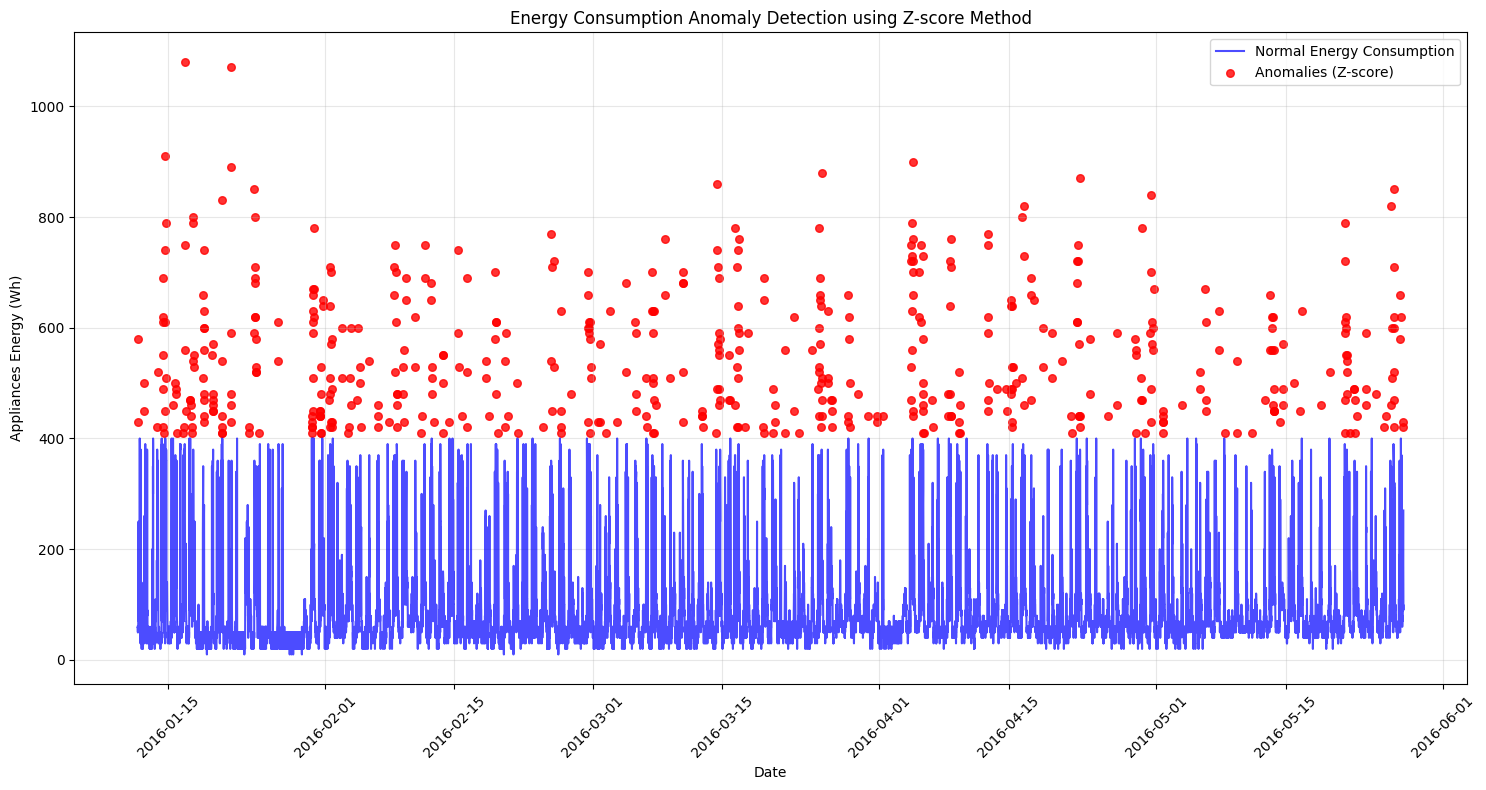

In [9]:
# Visualize the anomalies
plt.figure(figsize=(15, 8))

# Plot normal data points
normal_data = df[~df['is_anomaly_zscore']]
anomaly_data = df[df['is_anomaly_zscore']]

plt.plot(normal_data.index, normal_data['Appliances'],
         label='Normal Energy Consumption', alpha=0.7, color='blue')

# Plot anomalies
plt.scatter(anomaly_data.index, anomaly_data['Appliances'],
            color='red', label='Anomalies (Z-score)', s=30, alpha=0.8)

plt.title('Energy Consumption Anomaly Detection using Z-score Method')
plt.xlabel('Date')
plt.ylabel('Appliances Energy (Wh)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Print statistics about detected anomalies
total_points = len(df)
anomaly_count = df['is_anomaly_zscore'].sum()
anomaly_percentage = (anomaly_count / total_points) * 100

print(f"Total data points: {total_points}")
print(f"Anomalies detected: {anomaly_count}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")

# Show some example anomalies
print(f"\nTop 5 highest energy consumption anomalies:")
top_anomalies = df[df['is_anomaly_zscore']].nlargest(5, 'Appliances')
for idx, row in top_anomalies.iterrows():
    print(f"Date: {idx}, Energy: {row['Appliances']:.0f} Wh, Z-score: {row['z_score']:.2f}")

Total data points: 19735
Anomalies detected: 540
Anomaly percentage: 2.74%

Top 5 highest energy consumption anomalies:
Date: 2016-01-16 18:50:00, Energy: 1080 Wh, Z-score: 9.58
Date: 2016-01-21 18:50:00, Energy: 1070 Wh, Z-score: 9.48
Date: 2016-01-14 17:00:00, Energy: 910 Wh, Z-score: 7.92
Date: 2016-04-04 15:40:00, Energy: 900 Wh, Z-score: 7.83
Date: 2016-01-21 19:00:00, Energy: 890 Wh, Z-score: 7.73


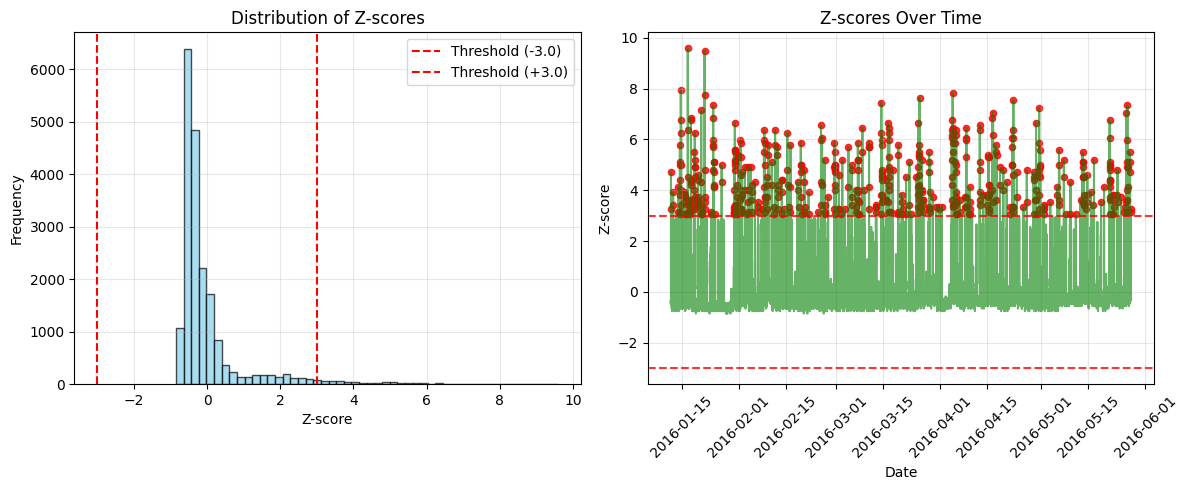

In [11]:
# Additional analysis: Distribution of Z-scores
plt.figure(figsize=(12, 5))

# Plot 1: Histogram of Z-scores
plt.subplot(1, 2, 1)
plt.hist(df['z_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(-z_threshold, color='red', linestyle='--', label=f'Threshold (-{z_threshold})')
plt.axvline(z_threshold, color='red', linestyle='--', label=f'Threshold (+{z_threshold})')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.title('Distribution of Z-scores')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Z-score over time
plt.subplot(1, 2, 2)
plt.plot(df.index, df['z_score'], alpha=0.6, color='green')
plt.axhline(z_threshold, color='red', linestyle='--', alpha=0.8)
plt.axhline(-z_threshold, color='red', linestyle='--', alpha=0.8)
plt.scatter(anomaly_data.index, anomaly_data['z_score'],
            color='red', s=20, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Z-score')
plt.title('Z-scores Over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

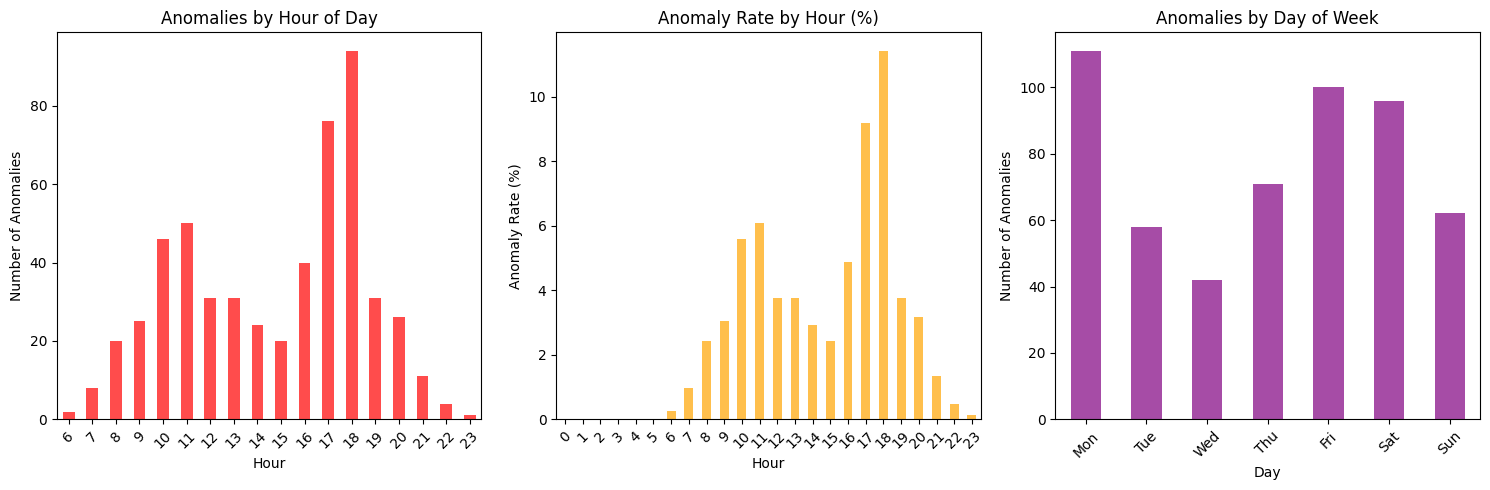

Peak anomaly hours:
hour
18    11.421628
17     9.178744
11     6.082725
10     5.596107
16     4.866180
dtype: float64


In [12]:
# Temporal analysis of anomalies
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Analyze anomalies by hour
hourly_anomalies = df[df['is_anomaly_zscore']].groupby('hour').size()
total_by_hour = df.groupby('hour').size()
hourly_anomaly_rate = (hourly_anomalies / total_by_hour * 100).fillna(0)

plt.figure(figsize=(15, 5))

# Plot anomalies by hour
plt.subplot(1, 3, 1)
hourly_anomalies.plot(kind='bar', color='red', alpha=0.7)
plt.title('Anomalies by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)

# Plot anomaly rate by hour
plt.subplot(1, 3, 2)
hourly_anomaly_rate.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Anomaly Rate by Hour (%)')
plt.xlabel('Hour')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(rotation=45)

# Plot anomalies by day of week
plt.subplot(1, 3, 3)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_anomalies = df[df['is_anomaly_zscore']].groupby('day_of_week').size()
daily_anomalies.index = [day_names[i] for i in daily_anomalies.index]
daily_anomalies.plot(kind='bar', color='purple', alpha=0.7)
plt.title('Anomalies by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Peak anomaly hours:")
print(hourly_anomaly_rate.sort_values(ascending=False).head())